## This script takes the predictions made from multiple models, compare them against the actual results, and determine how these models perform a statistical and operational context

### Outline of Notebook:

#### 4.1 Establish environment and creating threshold-evaluation functions
&nbsp;&nbsp;&nbsp;&nbsp;Function: <u>CSV_Reader()</u><br>
&nbsp;&nbsp;&nbsp;&nbsp;Function: <u>plot_histograms()</u><br>
&nbsp;&nbsp;&nbsp;&nbsp;Function: <u>Threshold_Evaluation()</u><br>
&nbsp;&nbsp;&nbsp;&nbsp;Function: <u>generate_thresholds()</u><br>
&nbsp;&nbsp;&nbsp;&nbsp;Function: <u>create_prediction_cutoff_lists()</u><br>
#### 4.2 Determine optimal XGBoost perdiction cutoff thresholds
#### 4.3 Determine optimal Linear Learner perdiction cutoff thresholds
#### 4.4 Determine optimal Stacked perdiction cutoff thresholds
#### 4.5 Default Comparisons
#### 4.6  Identifying Optimal Predictions
&nbsp;&nbsp;&nbsp;&nbsp;Function: <u>select_best_performer()</u><br>
&nbsp;&nbsp;&nbsp;&nbsp;Function: <u>optimal_model_barchart()</u><br>
&nbsp;&nbsp;&nbsp;&nbsp;Function: <u>Plot_Confusion_Matrix()</u><br>

## 4.1 Establish environment and creating threshold-evaluation functions

#### Importing Librries

In [1]:
#Data Manipulation Libraries
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import datetime

#Sagemaker/related Libraries
import sagemaker
from sagemaker import get_execution_role
import boto3
import io
from io import StringIO
from io import BytesIO
from sagemaker import get_execution_role
import sagemaker.amazon.common as smac
import os
smclient = boto3.Session().client('sagemaker')
s3 = boto3.client('s3')

#Data Visualization 
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, roc_auc_score, precision_recall_curve, auc

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


#### Increase the dimensions of the displayed dataset

In [2]:
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 500)

#### Defining variables to be used later

In [3]:
role = get_execution_role()
sagemaker_session = sagemaker.Session()
bucket = 'diabetes-directory'  # Replace with your S3 bucket name
input_prefix = 'processed_diabetes_data_3'  # Replace with the S3 prefix where your protobuf data is stored
test_with_predictions = "test_with_predictions.csv"
hist_figsize=(5, 3)
xgb = "xgb"
linear = "linear"
stacked = "stacked"
cost = "Net_Cost_Savings"
ROC_AUC = "ROC_AUC"
per_patient_savings = "Net_Cost_Savings"
Prevented_Readmissions = "Prevented_Readmissions"
stacked_predictions = "stacked_predictions"
columns_to_plot = ['xgb_predictions', 'linear_predictions', 'stacked_predictions']
xgb_predictions = "xgb_predictions"
linear_predictions = "linear_predictions"

#### Function to read in test dataset with predictions

In [4]:
def CSV_Reader(bucket, subfolder, source_file_name):
    
    '''The CSV_Reader() function takes in the names of the bucket, subfolder, and source file name, and desired dataframe name. 
    It first constructs the filepath, and then imports the file residing at this filepath, based on the title fed to the function.
    
    Arguments 
    --------- 
    bucket: Head S3 repository bucket
    subfolder: Subfolder containing the source data
    source_file_name: Name of source CSV data file 
    
    Return
    ---------
    Returns the source data in a pandas dataframe '''
    
    data_location = 's3://{}/{}/{}'.format(bucket, subfolder, source_file_name)  
    dataset = pd.read_csv(data_location, low_memory=False, header='infer')
    return dataset

In [5]:
diabetes_test = CSV_Reader(bucket, input_prefix, test_with_predictions)

In [6]:
print(diabetes_test.shape)
diabetes_test.columns

(15018, 65)


Index(['readmitted', 'num_lab_procedures', 'num_medications',
       'time_in_hospital', 'number_inpatient', 'num_procedures',
       'number_diagnoses', 'number_outpatient', 'number_emergency',
       'gender_Male', 'admission_source_id_1', 'change', 'diag_3_Nothing',
       'age_9', 'diag_2_Nothing', 'admission_type_id_3', 'diag_2_respiratory',
       'medication_insulin', 'age_6', 'medication_glyburide',
       'diag_2_urogenital', 'diag_3_metabolic',
       'discharge_disposition_hhealth', 'medication_metformin',
       'diag_3_respiratory', 'diag_1_digestive', 'diag_1_respiratory', 'age_5',
       'diag_1_injury', 'discharge_disposition_outpatient', 'diag_3_injury',
       'diag_3_urogenital', 'discharge_disposition_nursing', 'diag_1_Nothing',
       'any_medication', 'diag_1_urogenital', 'A1Cresult_Norm',
       'diag_3_digestive', 'discharge_disposition_unknown', 'A1Cresult_>7',
       'admission_source_id_8', 'diag_2_skin', 'diag_3_other', 'race_Other',
       'discharge_dispos

#### Below we will look at the distribution of predictions yeilded from our XGBoost, Linear Learner, and Stacked models

In [7]:
def plot_histograms(dataframe, columns, hist_figsize):
    
    
    '''The plot_histograms() function takes in the names of a dataset, and columns within that dataset, and produces 
    a histogram for each specified column

    Arguments 
    --------- 
    dataframe: Input dataframe (presumably the diabetes test dataset)
    columns: a list of specified columns within the dataset (presumably different prediction columns)
    hist_figsize: dimensions for the histogram '''
    
    for column in columns:
        # Create a wider figure
        plt.figure(figsize=hist_figsize)

        # Plot histogram for each column
        plt.hist(dataframe[column], bins=1000, density=True, alpha=0.7, label=column)
        plt.xlabel(f'Predicted Values for {column}')
        plt.ylabel('Frequency')
        plt.title(f'Distribution of Prediction Values from Model - {column}')

        # Calculate and add mean line to the histogram
        mean_value = np.mean(dataframe[column])
        plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mean Prediction Value: {mean_value:.2f}')

        # Display legend
        plt.legend()

        # Show the histogram
        plt.show()

        print(f'The mean predictive value for the {column} is: {mean_value}')


In [8]:
# Example usage with multiple columns
columns_to_plot = ['xgb_predictions', 'linear_predictions', 'stacked_predictions']

#### Below we view the predictionb distributions

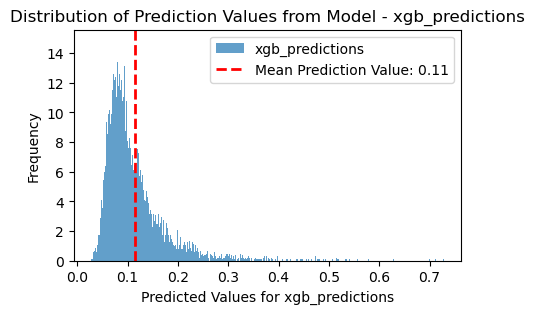

The mean predictive value for the xgb_predictions is: 0.11405916246543996


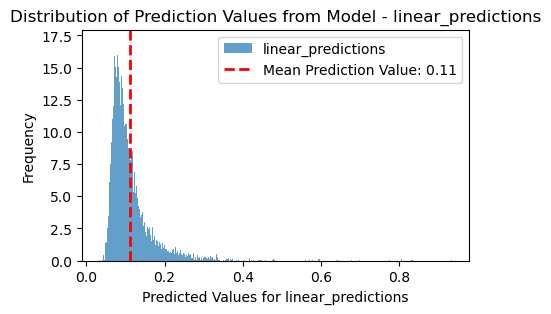

The mean predictive value for the linear_predictions is: 0.11265789014770378


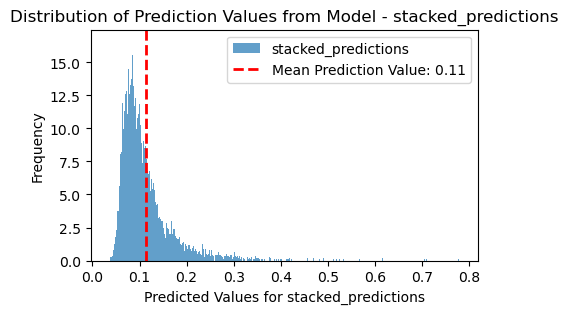

The mean predictive value for the stacked_predictions is: 0.11335852630657187


In [9]:
plot_histograms(diabetes_test, columns_to_plot, hist_figsize)

Across all of these models, we can see that the predictions demonstrate a relatively similar distribution, having an average prediction around 11%, with a peak below 10%, and a rightward skew towards 100%, with only a few predictions being made above 50%.

Indeed, this makes sense, as only 1 in 10 of our records was an actual readmission, and so it makes sense that these models are hesitant to place heavy weight on any specific prediction. The few predictions made above 50% are likely patients that demonstrate multiple factors identified as being correlated/connected with readmissions. 

Although the model is hesitant to make certain predictions, the ability of these models to rank these records in terms of their relative probability of being a readmission is very useful for our analytic purposes. 

We can identify different probability cutoff levels, and apply these levels to be more/less conservative with our predictions, to meet different operational goals.

#### Statistical v Operational assessment

To assess these results, we will need to determine the context with which we view them.

A common approach to assess a binary prediction problem, would be to look at the ROC AUC value. Indeed, this was the metric specified when optimizing our hyperparameters.

While we will certainly assess this metric across our 3 models by this metric, we will also be looking at operational considerations, (predominantly dollars saved and readmissions prevented). 

From this perspective, we will assume that once a patient is predicted as being at risk for readmission, they will be enrolled within a diabetes-management-program. This program will provide the support and tools necessary to prevent a readmission.

In this paradime, it is proportionally more important to prevent a readmission than to waste resources on inappropriatley treating a patient who would not have been readmitted

#### Parameters specified for the operational assessments of our models

In [10]:
cost_of_management_program = 500
sucess_rate_of_intervention = 0.5
cost_of_readmission = 15000

As can be seen from the variables above, we are using the approximate values for our assessment:

There is a per-patient expense of implimenting a diabetes-management-program for one month<br/>
There is a 50% chance that the application of this program will result in a prevented readmission<br/>
Every prevented readmission saves $15,000 (i.e. the cost of a readmission)

Of particular, note, these values are mere aproximations, and are likely to vary across geography and health systems. As such, changes to these parameters may change the implications of our assessment considerably.

However, this provides a realistic baseline, and an understanding of how these models might be applied to create operationally optimized prediction models.

#### The below function will assess our predictions across a range of cutoff values, and will print/save these results so that different cutoff levels meeting different purposes can be identified.

In [11]:
def Threshold_Evaluation(probability_rounding_threshold_values, names_of_levels, evaluation_name,
                         outcome_metric_1, outcome_metric_2):
    
    '''The Threshold_Evaluation() function takes different readmission predictions, based on different likelihood roundoff 
    values, and computes various metrics.
    
    Prints the output of the assessments and calculations made.
    
    Arguments: 
    --------- 
    probability_rounding_threshold_values: A list of probabilities as calculated from each specified prediction 
        cutoff level
    names_of_levels: A list of probabilities, corresponding to each probability iteration of probability_rounding_threshold_values 
    evaluation_name: specified if the predictions are yielded from an XGBoost, Linear Learner, or Stacked model
    outcome_metric_1: specifies the outcome metric being assessed (petient savings, or AUC)
    outcome_metric_2: if applicable, specifies the outcome metric being assessed (petient savings, or AUC)
    
    
    Returns:
    ---------
    result_df: Returns a dataframe representing the output of a model, enabling cross-model assessment
    '''

    result_list = []

    for i, j in zip(probability_rounding_threshold_values, names_of_levels):
        y_test = diabetes_test['readmitted']
        
        #Calculating various statistical and operational metrics
        acc = accuracy_score(y_test, i)
        roc_auc = roc_auc_score(y_test, i)
        precision, recall, _ = precision_recall_curve(y_test, i)
        pr_auc = auc(recall, precision)       
        cm = confusion_matrix(y_test, i)    
        true_positives = cm[1, 1]
        false_positives = cm[0, 1]
        true_negatives = cm[0, 0]
        false_negatives = cm[1, 0]
        
        recall = true_positives/(true_positives+false_negatives)
        precision = true_positives/(true_positives+false_positives)
        specificity = true_negatives/(true_negatives+false_positives)
        f1_score = (2*true_positives)/(2*true_positives + false_positives + false_negatives)
        
        total_cost_of_implimenting_program = cost_of_management_program*(true_positives+false_positives)
        per_patient_outlay = round(total_cost_of_implimenting_program/len(i), 2)
        readmissions_prevented = round(sucess_rate_of_intervention*true_positives)
        savings_from_readmissions_prevention = round((readmissions_prevented) * (cost_of_readmission), 2)
        per_patient_savings_from_readmissions_prevention = round((savings_from_readmissions_prevention/len(i)), 2)
        net_savings_to_hosptial_system = (savings_from_readmissions_prevention) - (total_cost_of_implimenting_program)
        net_per_patient_savings = round(net_savings_to_hosptial_system/len(i), 2)

        # Add these metrics to a dictionary
        result_dict = {

            'Cutoff_Percentage': j,
            'ROC_AUC': roc_auc,
            'Net_Cost_Savings': net_per_patient_savings,
            'Prevented_Readmissions': readmissions_prevented,
            'Recall': recall,
            'Precision': precision,
            'F1_Score': f1_score,
            'Accuracy': acc,
            'PR AUC': pr_auc,
            'True_Positives': true_positives,
            'False_Positives': false_positives,
            'False_Negatives': false_negatives,
            'Specificity': specificity,
            'Per-Patient Savings': per_patient_savings_from_readmissions_prevention,
            'Up_front_Expense': per_patient_outlay,
            'Type_of_assessment': evaluation_name

        }
        result_list.append(result_dict)

        # Print the results saved in the dictionary
        #Other metrics are listed below, but are not currently included due to the length of the output. 
        #These are recorded in the output dataframe however. 
        print('The cutoff percentage being used for predictions is: {}'.format(j))
        print()
        print('Statistics:')
        print('ROC AUC score is: {}'.format(roc_auc))
        print('Recall is: {}'.format(recall))
        print('Precision is: {}'.format(precision))
        print('True Positives: {}'.format(true_positives))
        #print('False Positives: {}'.format(false_positives))
        #print('False Negatives: {}'.format(false_negatives))
        #print('PR AUC score is: {}'.format(pr_auc))
        #print('Specificity is: {}'.format(specificity))
        #print('F1 score is: {}'.format(f1_score))
        #print('Accuracy is: {}'.format(acc))
        print()
        print('Operational Metrics:')
        print('The net per-patient savings would be: ${}'.format(net_per_patient_savings))
        print('Number of prevented readmissions: {}'.format(readmissions_prevented))
        #print('The per-patient savings from prevented readmissions would be: ${}'.format(per_patient_savings_from_readmissions_prevention))
        #print("The up-front per patient expense from implementing the intervention program would be: ${}".format(per_patient_outlay))
        print()
        print()

    # Save the output dictionaries to a DataFrame
    result_df = pd.DataFrame(result_list)

    top_row_series = result_df.sort_values(by=outcome_metric_1, ascending=False).head(1).iloc[0]

    # Print the top row as a Series
    print(f"Optimal result for predictions using {outcome_metric_1}:")
    print(top_row_series)
    print()
    print()
    
    # If outcome_metric_2 is provided, sort and print based on it
    if outcome_metric_2 is not None:
        top_row_series_2 = result_df.sort_values(by=outcome_metric_2, ascending=False).head(1).iloc[0]
        print(f"Optimal result for predictions using {outcome_metric_2}:")
        print(top_row_series_2)
   
    return result_df


#### This functions creates a range of threshold cutoff values

In [12]:
def generate_thresholds(initial_value, total_range, increment, decimal_rounding_place):

    '''The generate_thresholds() function takes an initial threshold value, a range to be applied both above 
    and below this threshold, and an incriment by which to move above/below this initial value, to the range 
    specified, and lastly number of decimal places of the output to be returned. The function then provides 
    a list of threshold values that correspond to the values/range/incriments specified.
    
    Arguments 
    --------- 
    initial_value: A decimal value to be used as the initial prediction cutoff value.
    total_range: The range above/below the initial value that we wish our cutoff list to extend to.
    increment: The incriment by which the returned list will iterate between the initial, and max/min range
    of cutoff values
    decimal_rounding_place: the number of decimal places in the returned output
    
    Return
    ---------
    Returns a list of decimal values, which will constitute the range of prediction cutoff values we will use to assess 
    our models'''    
 
    #Define an empy list to be populated with thresholds
    thresholds = []

    # Generate values in descending order (above and below the initial value)
    for i in range(int(total_range/increment), 0, -1):
        value_above = round(initial_value + i * increment, decimal_rounding_place)
        value_below = round(initial_value - i * increment, decimal_rounding_place)
        
        #add these cutoff values to our list
        thresholds.extend([value_above, value_below])

    # Include the initial value
    thresholds.append(round(initial_value, decimal_rounding_place))
    thresholds = sorted(thresholds, reverse=True)

    return thresholds

#### This function produces a list of predictions made a different cutoff levels, and a seperate list of percentages that correspond sequentially with the cutoff values of this list for labeling purposes

In [13]:
def create_prediction_cutoff_lists(thresholds, column_name):
    
    '''The create_prediction_cutoff_lists() function takes a list of thresholds (i.e. the output of the above 
    generate_thresholds() function) along with the prediction column from the test dataset being compared. It
    then 
    
    Arguments 
    --------- 
    thresholds: a list of thresholds, typically provided by the generate_thresholds() function
    column_name: The name of the predictions column being used
    
    Return
    ---------
    Returns a list of decimal values, which will constitute the range of prediction cutoff values we will use to assess 
    our models'''  
    
    result_lists = []
    name_list = []
    for threshold in thresholds:
        threshold_str = str(threshold).replace(".", "_")
        variable_name = f"pred_{threshold_str}"
        output_variable_name = f"pred_{threshold_str[2:]}"
        result_list = [1 if i >= threshold else 0 for i in diabetes_test[column_name]]
        globals()[output_variable_name] = result_list
        result_lists.append(result_list)
    
    name_list = [f'{decimal * 100:.2f}%' for decimal in thresholds]
    
    return result_lists, name_list   # Move the return statement outside of the for loop

## 4.2 Determine optimal XGBoost perdiction cutoff thresholds

#### 4.2.1 XGB Initial thresholds (0.01)

We will begin by implimenting a wide range of cutoff values, centering around 11% (as this was the approximate average prediction value). From here, we can see where the best AUC/savings occur, and then see if a more precise cutoff value can improve these outcomes even further.

First we define the range of values we will use in determining our thresholds

In [14]:
xgb_initial_threshold_list_parameters = [0.11, 0.03, 0.01, 2]

Next we create a list of predictions at each threshold, and a list of the thresholds being used, so that we can then assess these predictions.

In [15]:
xgb_initial_thresholds, xgb_initial_threshold_list = create_prediction_cutoff_lists(generate_thresholds(*xgb_initial_threshold_list_parameters),
                                                                                    xgb_predictions)

print(len(xgb_initial_thresholds))
print(xgb_initial_thresholds[0][0:10])
print(xgb_initial_threshold_list)

7
[0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
['14.00%', '13.00%', '12.00%', '11.00%', '10.00%', '9.00%', '8.00%']


We now evaluate these predictions, made at various cutoff thresholds.

In [16]:
xgb_initial_data = Threshold_Evaluation(xgb_initial_thresholds, xgb_initial_threshold_list, "xgb", ROC_AUC, cost)

The cutoff percentage being used for predictions is: 14.00%

Statistics:
ROC AUC score is: 0.6101660412378732
Recall is: 0.41408114558472553
Precision is: 0.21164989326014028
True Positives: 694

Operational Metrics:
The net per-patient savings would be: $237.42
Number of prevented readmissions: 347


The cutoff percentage being used for predictions is: 13.00%

Statistics:
ROC AUC score is: 0.6141974452882476
Recall is: 0.4659904534606205
Precision is: 0.19767147557580358
True Positives: 781

Operational Metrics:
The net per-patient savings would be: $257.99
Number of prevented readmissions: 390


The cutoff percentage being used for predictions is: 12.00%

Statistics:
ROC AUC score is: 0.6214721022027806
Recall is: 0.5399761336515513
Precision is: 0.18590797041906326
True Positives: 905

Operational Metrics:
The net per-patient savings would be: $289.39
Number of prevented readmissions: 452


The cutoff percentage being used for predictions is: 11.00%

Statistics:
ROC AUC score is: 0.

From here, we can see that the optimal AUC for an xgboost model occurs at an 11% prediction cutoff point, and the optimal dollars saved occurs at 8% cutoff point.

#### 4.2.1.1 XGB precise thresholds (0.001) for optimized AUC

We will now define a precise range of threshold cutoff values for AUC, based on the above assessment.

In [17]:
xgb_precise_threshold_list_parameters_auc = [0.11, 0.005, 0.001, 3]

Next we create a list of predictions at each threshold, and a list of the thresholds being used, so that we can then assess these predictions.

In [18]:
xgb_precise_thresholds_auc, xgb_precise_threshold_list_auc = create_prediction_cutoff_lists(
    generate_thresholds(*xgb_precise_threshold_list_parameters_auc),
    'xgb_predictions')

print(len(xgb_precise_thresholds_auc))
print(xgb_precise_thresholds_auc[0][0:10])
print(xgb_precise_threshold_list_auc)

11
[0, 0, 1, 1, 0, 0, 1, 0, 0, 0]
['11.50%', '11.40%', '11.30%', '11.20%', '11.10%', '11.00%', '10.90%', '10.80%', '10.70%', '10.60%', '10.50%']


We now evaluate these predictions, made at various cutoff thresholds.

In [19]:
xgb_auc_precise_data = Threshold_Evaluation(xgb_precise_thresholds_auc, xgb_precise_threshold_list_auc,
                                            "xgb", ROC_AUC, None)

The cutoff percentage being used for predictions is: 11.50%

Statistics:
ROC AUC score is: 0.620318898920952
Recall is: 0.5668257756563246
Precision is: 0.1791776688042248
True Positives: 950

Operational Metrics:
The net per-patient savings would be: $297.91
Number of prevented readmissions: 475


The cutoff percentage being used for predictions is: 11.40%

Statistics:
ROC AUC score is: 0.6214239831221878
Recall is: 0.5745823389021479
Precision is: 0.178697346446465
True Positives: 963

Operational Metrics:
The net per-patient savings would be: $302.0
Number of prevented readmissions: 482


The cutoff percentage being used for predictions is: 11.30%

Statistics:
ROC AUC score is: 0.6207736152884874
Recall is: 0.5799522673031027
Precision is: 0.1771459814106069
True Positives: 972

Operational Metrics:
The net per-patient savings would be: $302.74
Number of prevented readmissions: 486


The cutoff percentage being used for predictions is: 11.20%

Statistics:
ROC AUC score is: 0.6221006

The best AUC is at 11.1%

#### 4.2.1.2 XGBoost more precise thresholds (0.0001) for optimized AUC

We will now define a more precise range of threshold cutoff values for AUC, based on the above assessment.

In [20]:
xgb_more_precise_threshold_list_parameters_auc = [0.11, 0.0005, 0.0001, 5]

Next we create a list of predictions at each threshold, and a list of the thresholds being used, so that we can then assess these predictions.

In [21]:
xgb_more_precise_thresholds_auc, xgb_more_precise_threshold_list_auc = create_prediction_cutoff_lists(
    generate_thresholds(*xgb_more_precise_threshold_list_parameters_auc),
    'xgb_predictions')

print(len(xgb_more_precise_thresholds_auc))
print(xgb_more_precise_thresholds_auc[0][0:10])
print(xgb_more_precise_threshold_list_auc)

11
[0, 0, 1, 1, 0, 0, 1, 0, 0, 0]
['11.05%', '11.04%', '11.03%', '11.02%', '11.01%', '11.00%', '10.99%', '10.98%', '10.97%', '10.96%', '10.95%']


We now evaluate these predictions, made at various cutoff thresholds.

In [22]:
xgb_auc_more_precise_data = Threshold_Evaluation(xgb_more_precise_thresholds_auc, 
                            xgb_more_precise_threshold_list_auc, 'xgb', ROC_AUC, None)

The cutoff percentage being used for predictions is: 11.05%

Statistics:
ROC AUC score is: 0.6243931003320395
Recall is: 0.6014319809069213
Precision is: 0.17643969893225975
True Positives: 1008

Operational Metrics:
The net per-patient savings would be: $313.19
Number of prevented readmissions: 504


The cutoff percentage being used for predictions is: 11.04%

Statistics:
ROC AUC score is: 0.6240183439237049
Recall is: 0.6014319809069213
Precision is: 0.17613139961558624
True Positives: 1008

Operational Metrics:
The net per-patient savings would be: $312.86
Number of prevented readmissions: 504


The cutoff percentage being used for predictions is: 11.03%

Statistics:
ROC AUC score is: 0.623941916870979
Recall is: 0.6020286396181385
Precision is: 0.1759679107080572
True Positives: 1009

Operational Metrics:
The net per-patient savings would be: $312.49
Number of prevented readmissions: 504


The cutoff percentage being used for predictions is: 11.02%

Statistics:
ROC AUC score is: 0.

10.97% is optimal for AUC and XGBoost

#### 4.2.2 XGBoost precise thresholds (0.001) for optimized net per-patient savings

We will now define a precise range of threshold cutoff values for cost savings, based on the above assessment.

In [23]:
xgb_precise_threshold_list_parameters_cost = [0.08, 0.005, 0.001, 3]

Next we create a list of predictions at each threshold, and a list of the thresholds being used, so that we can then assess these predictions.

In [24]:
xgb_precise_thresholds_cost, xgb_precise_threshold_list_cost = create_prediction_cutoff_lists(
    generate_thresholds(*xgb_precise_threshold_list_parameters_cost),
    'xgb_predictions')

print(len(xgb_precise_thresholds_cost))
print(xgb_precise_thresholds_cost[0][0:10])
print(xgb_precise_threshold_list_cost)

11
[1, 1, 1, 1, 1, 0, 1, 0, 0, 1]
['8.50%', '8.40%', '8.30%', '8.20%', '8.10%', '8.00%', '7.90%', '7.80%', '7.70%', '7.60%', '7.50%']


We now evaluate these predictions, made at various cutoff thresholds.

In [25]:
xgb_cost_precise_data = Threshold_Evaluation(xgb_precise_thresholds_cost, xgb_precise_threshold_list_cost, 
                                             "xgb", cost, None)

The cutoff percentage being used for predictions is: 8.50%

Statistics:
ROC AUC score is: 0.6037713463575645
Recall is: 0.8025059665871122
Precision is: 0.1448885058709469
True Positives: 1345

Operational Metrics:
The net per-patient savings would be: $362.13
Number of prevented readmissions: 672


The cutoff percentage being used for predictions is: 8.40%

Statistics:
ROC AUC score is: 0.6016520496760638
Recall is: 0.8108591885441527
Precision is: 0.14358161648177495
True Positives: 1359

Operational Metrics:
The net per-patient savings would be: $364.06
Number of prevented readmissions: 680


The cutoff percentage being used for predictions is: 8.30%

Statistics:
ROC AUC score is: 0.5994203260720627
Recall is: 0.8192124105011933
Precision is: 0.142279792746114
True Positives: 1373

Operational Metrics:
The net per-patient savings would be: $363.9
Number of prevented readmissions: 686


The cutoff percentage being used for predictions is: 8.20%

Statistics:
ROC AUC score is: 0.596779

as can be seen 7.70% is optimal for xgboost cost

#### 4.2.2.1 XGBoost more precise thresholds (0.0001) for optimized net per-patient savings

We will now define a more precise range of threshold cutoff values for cost savings, based on the above assessment.

In [26]:
xgb_more_precise_threshold_list_parameters_cost = [0.077, 0.0003, 0.0001, 5]

Next we create a list of predictions at each threshold, and a list of the thresholds being used, so that we can then assess these predictions.

In [27]:
xgb_more_precise_thresholds_cost, xgb_more_precise_threshold_list_cost = create_prediction_cutoff_lists(
    generate_thresholds(*xgb_more_precise_threshold_list_parameters_cost),
    'xgb_predictions')

print(len(xgb_more_precise_thresholds_cost))
print(xgb_more_precise_thresholds_cost[0][0:10])
print(xgb_more_precise_threshold_list_cost)

5
[1, 1, 1, 1, 1, 0, 1, 0, 0, 1]
['7.72%', '7.71%', '7.70%', '7.69%', '7.68%']


We now evaluate these predictions, made at various cutoff thresholds.

In [28]:
xgb_cost_more_precise_data = Threshold_Evaluation(xgb_more_precise_thresholds_cost,
                    xgb_more_precise_threshold_list_cost, "xgb", cost, None)

The cutoff percentage being used for predictions is: 7.72%

Statistics:
ROC AUC score is: 0.5827887887193133
Recall is: 0.8615751789976134
Precision is: 0.13457595526561045
True Positives: 1444

Operational Metrics:
The net per-patient savings would be: $363.9
Number of prevented readmissions: 722


The cutoff percentage being used for predictions is: 7.71%

Statistics:
ROC AUC score is: 0.5831591178144707
Recall is: 0.8633651551312649
Precision is: 0.1346422257374151
True Positives: 1447

Operational Metrics:
The net per-patient savings would be: $365.33
Number of prevented readmissions: 724


The cutoff percentage being used for predictions is: 7.70%

Statistics:
ROC AUC score is: 0.5830062637090188
Recall is: 0.8645584725536993
Precision is: 0.1345528832760702
True Positives: 1449

Operational Metrics:
The net per-patient savings would be: $364.6
Number of prevented readmissions: 724


The cutoff percentage being used for predictions is: 7.69%

Statistics:
ROC AUC score is: 0.583003

optimal xgb cost savings at 7.69% cutoff: $366

## 4.3 Determine optimal Linear Learner perdiction cutoff thresholds

#### 4.3.1 Linear Learner Initial thresholds (0.01)

We will now define a precise range of threshold cutoff values for AUC, based on the above assessment.

In [29]:
ll_initial_threshold_list_parameters = [0.11, 0.03, 0.01, 2]

Next we create a list of predictions at each threshold, and a list of the thresholds being used, so that we can then assess these predictions.

In [30]:
ll_initial_thresholds, ll_initial_threshold_list = create_prediction_cutoff_lists(
    generate_thresholds(*ll_initial_threshold_list_parameters), 'linear_predictions')

print(len(ll_initial_thresholds))
print(ll_initial_thresholds[0][0:10])
print(ll_initial_threshold_list)

7
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
['14.00%', '13.00%', '12.00%', '11.00%', '10.00%', '9.00%', '8.00%']


We now evaluate these predictions, made at various cutoff thresholds.

In [31]:
ll_initial_data = Threshold_Evaluation(ll_initial_thresholds, ll_initial_threshold_list, 'linear',  
                                       ROC_AUC, cost)

The cutoff percentage being used for predictions is: 14.00%

Statistics:
ROC AUC score is: 0.5933908621687073
Recall is: 0.3478520286396181
Precision is: 0.21339677891654465
True Positives: 583

Operational Metrics:
The net per-patient savings would be: $200.69
Number of prevented readmissions: 292


The cutoff percentage being used for predictions is: 13.00%

Statistics:
ROC AUC score is: 0.602163963352222
Recall is: 0.40692124105011934
Precision is: 0.2014771048744461
True Positives: 682

Operational Metrics:
The net per-patient savings would be: $227.89
Number of prevented readmissions: 341


The cutoff percentage being used for predictions is: 12.00%

Statistics:
ROC AUC score is: 0.6132508052343542
Recall is: 0.4850835322195704
Precision is: 0.19071076706544687
True Positives: 813

Operational Metrics:
The net per-patient savings would be: $263.58
Number of prevented readmissions: 406


The cutoff percentage being used for predictions is: 11.00%

Statistics:
ROC AUC score is: 0.61

From here, we can see that the optimal AUC for an Linear Learner model occurs at an 11% prediction cutoff point, and the optimal dollars saved occurs at 8% cutoff point.

#### 4.3.1.2 Linear Learner precise thresholds (0.001) for optimized AUC

We will now define a precise range of threshold cutoff values for AUC, based on the above assessment.

In [32]:
ll_precise_threshold_list_parameters = [0.11, 0.005, 0.001, 3]

Next we create a list of predictions at each threshold, and a list of the thresholds being used, so that we can then assess these predictions.

In [33]:
ll_precise_threshold, ll_precise_threshold_list = create_prediction_cutoff_lists(
    generate_thresholds(*ll_precise_threshold_list_parameters),
    'linear_predictions')

print(len(ll_precise_threshold))
print(ll_precise_threshold[0][0:10])
print(ll_precise_threshold_list)

11
[0, 0, 1, 0, 0, 1, 1, 0, 0, 0]
['11.50%', '11.40%', '11.30%', '11.20%', '11.10%', '11.00%', '10.90%', '10.80%', '10.70%', '10.60%', '10.50%']


We now evaluate these predictions, made at various cutoff thresholds.

In [34]:
ll_auc_precise_data = Threshold_Evaluation(ll_precise_threshold, ll_precise_threshold_list, 'linear',
                                           ROC_AUC, None)

The cutoff percentage being used for predictions is: 11.50%

Statistics:
ROC AUC score is: 0.6173403457203892
Recall is: 0.5286396181384249
Precision is: 0.18427620632279534
True Positives: 886

Operational Metrics:
The net per-patient savings would be: $282.39
Number of prevented readmissions: 443


The cutoff percentage being used for predictions is: 11.40%

Statistics:
ROC AUC score is: 0.6159044652002452
Recall is: 0.5334128878281623
Precision is: 0.18178121187474583
True Positives: 894

Operational Metrics:
The net per-patient savings would be: $282.73
Number of prevented readmissions: 447


The cutoff percentage being used for predictions is: 11.30%

Statistics:
ROC AUC score is: 0.6154370482575346
Recall is: 0.5405727923627685
Precision is: 0.1798332671695117
True Positives: 906

Operational Metrics:
The net per-patient savings would be: $284.72
Number of prevented readmissions: 453


The cutoff percentage being used for predictions is: 11.20%

Statistics:
ROC AUC score is: 0.61

As can be seen, the optimal AUC is encountered at 11%

#### 4.3.1.3 Linear Learner more precise thresholds (0.0001) for optimized AUC

We will now define a more precise range of threshold cutoff values for AUC, based on the above assessment.

In [35]:
ll_more_precise_threshold_list_parameters_auc = [0.11, 0.0005, 0.0001, 5]

Next we create a list of predictions at each threshold, and a list of the thresholds being used, so that we can then assess these predictions.

In [36]:
ll_more_precise_thresholds_auc, ll_more_precise_threshold_list_auc = create_prediction_cutoff_lists(
    generate_thresholds(*ll_more_precise_threshold_list_parameters_auc),
    'linear_predictions')

print(len(ll_more_precise_thresholds_auc))
print(ll_more_precise_thresholds_auc[0][0:10])
print(ll_more_precise_threshold_list_auc)

11
[0, 0, 1, 0, 0, 1, 1, 0, 0, 0]
['11.05%', '11.04%', '11.03%', '11.02%', '11.01%', '11.00%', '10.99%', '10.98%', '10.97%', '10.96%', '10.95%']


We now evaluate these predictions, made at various cutoff thresholds.

In [37]:
ll_auc_more_precise_data = Threshold_Evaluation(ll_more_precise_thresholds_auc, ll_more_precise_threshold_list_auc,
                                               "linear", ROC_AUC, None)

The cutoff percentage being used for predictions is: 11.05%

Statistics:
ROC AUC score is: 0.618262165988289
Recall is: 0.565035799522673
Precision is: 0.1776735459662289
True Positives: 947

Operational Metrics:
The net per-patient savings would be: $295.98
Number of prevented readmissions: 474


The cutoff percentage being used for predictions is: 11.04%

Statistics:
ROC AUC score is: 0.6181107876538962
Recall is: 0.5656324582338902
Precision is: 0.17742841100505333
True Positives: 948

Operational Metrics:
The net per-patient savings would be: $295.55
Number of prevented readmissions: 474


The cutoff percentage being used for predictions is: 11.03%

Statistics:
ROC AUC score is: 0.6174362261188939
Recall is: 0.5656324582338902
Precision is: 0.17683268047006157
True Positives: 948

Operational Metrics:
The net per-patient savings would be: $294.95
Number of prevented readmissions: 474


The cutoff percentage being used for predictions is: 11.02%

Statistics:
ROC AUC score is: 0.6180

The best Linear AUC value of .618 can be found at an 11.01% cutoff threshold

#### 4.3.2 Linear Learner precise thresholds (0.001) for optimized net per-patient savings

We will now define a precise range of threshold cutoff values for cost savings, based on the above assessment.

In [38]:
ll_precise_threshold_list_parameters_cost = [0.08, 0.003, 0.001, 3]

Next we create a list of predictions at each threshold, and a list of the thresholds being used, so that we can then assess these predictions.

In [39]:
ll_precise_threshold_cost, ll_precise_threshold_list_cost = create_prediction_cutoff_lists(
    generate_thresholds(*ll_precise_threshold_list_parameters_cost),
    'linear_predictions')

print(len(ll_precise_threshold_cost))
print(ll_precise_threshold_cost[0][0:10])
print(ll_precise_threshold_list_cost)

7
[1, 1, 1, 1, 0, 1, 1, 1, 0, 1]
['8.30%', '8.20%', '8.10%', '8.00%', '7.90%', '7.80%', '7.70%']


We now evaluate these predictions, made at various cutoff thresholds.

In [40]:
ll_cost_precise_data = Threshold_Evaluation(ll_precise_threshold_cost, ll_precise_threshold_list_cost,
                                            "linear", cost, None)

The cutoff percentage being used for predictions is: 8.30%

Statistics:
ROC AUC score is: 0.5851648248447577
Recall is: 0.8251789976133651
Precision is: 0.1366600790513834
True Positives: 1383

Operational Metrics:
The net per-patient savings would be: $354.24
Number of prevented readmissions: 692


The cutoff percentage being used for predictions is: 8.20%

Statistics:
ROC AUC score is: 0.5835958566072863
Recall is: 0.8383054892601431
Precision is: 0.1356308523988802
True Positives: 1405

Operational Metrics:
The net per-patient savings would be: $356.27
Number of prevented readmissions: 702


The cutoff percentage being used for predictions is: 8.10%

Statistics:
ROC AUC score is: 0.58001648570434
Recall is: 0.8460620525059666
Precision is: 0.13414057326648376
True Positives: 1418

Operational Metrics:
The net per-patient savings would be: $356.21
Number of prevented readmissions: 709


The cutoff percentage being used for predictions is: 8.00%

Statistics:
ROC AUC score is: 0.576282

best at 8.20%

#### 4.3.2.1 Linear Learner more precise thresholds (0.0001) for optimized net per-patient savings

We will now define a more precise range of threshold cutoff values for cost savings, based on the above assessment.

In [41]:
ll_more_precise_threshold_list_parameters_cost = [0.082, 0.0003, 0.0001, 5]

Next we create a list of predictions at each threshold, and a list of the thresholds being used, so that we can then assess these predictions.

In [42]:
ll_more_precise_thresholds_cost, ll_more_precise_threshold_list_cost = create_prediction_cutoff_lists(
    generate_thresholds(*ll_more_precise_threshold_list_parameters_cost),
    'linear_predictions')

print(len(ll_more_precise_thresholds_cost))
print(ll_more_precise_thresholds_cost[0][0:10])
print(ll_more_precise_threshold_list_cost)

5
[1, 1, 1, 1, 1, 1, 1, 1, 0, 1]
['8.22%', '8.21%', '8.20%', '8.19%', '8.18%']


We now evaluate these predictions, made at various cutoff thresholds.

In [43]:
ll_cost_more_precise_data = Threshold_Evaluation(ll_more_precise_thresholds_cost, ll_more_precise_threshold_list_cost,
                                                "linear", cost, None)

The cutoff percentage being used for predictions is: 8.22%

Statistics:
ROC AUC score is: 0.5833049061069733
Recall is: 0.8347255369928401
Precision is: 0.1356540288955687
True Positives: 1399

Operational Metrics:
The net per-patient savings would be: $355.81
Number of prevented readmissions: 700


The cutoff percentage being used for predictions is: 8.21%

Statistics:
ROC AUC score is: 0.5837112350719049
Recall is: 0.8371121718377088
Precision is: 0.13571290384987425
True Positives: 1403

Operational Metrics:
The net per-patient savings would be: $356.97
Number of prevented readmissions: 702


The cutoff percentage being used for predictions is: 8.20%

Statistics:
ROC AUC score is: 0.5835958566072863
Recall is: 0.8383054892601431
Precision is: 0.1356308523988802
True Positives: 1405

Operational Metrics:
The net per-patient savings would be: $356.27
Number of prevented readmissions: 702


The cutoff percentage being used for predictions is: 8.19%

Statistics:
ROC AUC score is: 0.5834

8.19 is optimal ll cost cutoff for $357.57

## 4.4 Determine optimal Stacked perdiction cutoff thresholds

We will now define an initial range of threshold cutoff values to evaluate our stacked model predictions, begining around 11% as this was the average prediction.

#### 4.4.1  Stacked Initial thresholds (0.01)

In [44]:
stacked_initial_threshold_list_parameters = [0.11, 0.03, 0.01, 3]

Next we create a list of predictions at each threshold, and a list of the thresholds being used, so that we can then assess these predictions.

In [45]:
stacked_initial_thresholds, stacked_initial_threshold_list = (

create_prediction_cutoff_lists(generate_thresholds(*stacked_initial_threshold_list_parameters),
                                                                                    stacked_predictions))

print(len(stacked_initial_thresholds))
print(stacked_initial_thresholds[0][0:10])
print(stacked_initial_threshold_list)

7
[0, 0, 1, 0, 0, 0, 1, 0, 0, 0]
['14.00%', '13.00%', '12.00%', '11.00%', '10.00%', '9.00%', '8.00%']


We now evaluate these predictions, made at various cutoff thresholds.

In [46]:
stacked_initial = Threshold_Evaluation(stacked_initial_thresholds, stacked_initial_threshold_list, 
                                          stacked, ROC_AUC, cost)

The cutoff percentage being used for predictions is: 14.00%

Statistics:
ROC AUC score is: 0.6072329238977958
Recall is: 0.38782816229116945
Precision is: 0.2193722578467769
True Positives: 650

Operational Metrics:
The net per-patient savings would be: $225.96
Number of prevented readmissions: 325


The cutoff percentage being used for predictions is: 13.00%

Statistics:
ROC AUC score is: 0.6154769387964649
Recall is: 0.4486873508353222
Precision is: 0.2056330325403336
True Positives: 752

Operational Metrics:
The net per-patient savings would be: $253.8
Number of prevented readmissions: 376


The cutoff percentage being used for predictions is: 12.00%

Statistics:
ROC AUC score is: 0.6190636438343715
Recall is: 0.5137231503579952
Precision is: 0.18973115910092553
True Positives: 861

Operational Metrics:
The net per-patient savings would be: $278.4
Number of prevented readmissions: 430


The cutoff percentage being used for predictions is: 11.00%

Statistics:
ROC AUC score is: 0.6226

We can see that 11% optimizes AUC, and 8% optimizes cost savings.

#### 4.4.1 Staked model with precise thresholds (0.001) for optimized AUC

In [47]:
stacked_auc_precise_threshold_list_parameters = [0.11, 0.005, 0.001, 3]

Next we create a list of predictions at each threshold, and a list of the thresholds being used, so that we can then assess these predictions.

In [48]:
stacked_auc_precise_thresholds, stacked_auc_precise_threshold_list = (

create_prediction_cutoff_lists(generate_thresholds(*stacked_auc_precise_threshold_list_parameters),
                                                                                    stacked_predictions))

print(len(stacked_auc_precise_thresholds))
print(stacked_auc_precise_thresholds[0][0:10])
print(stacked_auc_precise_threshold_list)

11
[0, 0, 1, 0, 0, 0, 1, 0, 0, 0]
['11.50%', '11.40%', '11.30%', '11.20%', '11.10%', '11.00%', '10.90%', '10.80%', '10.70%', '10.60%', '10.50%']


We now evaluate these predictions, made at various cutoff thresholds.

In [49]:
precise_stacked_auc = Threshold_Evaluation(stacked_auc_precise_thresholds, stacked_auc_precise_threshold_list, 
                                          stacked, ROC_AUC, None)

The cutoff percentage being used for predictions is: 11.50%

Statistics:
ROC AUC score is: 0.6217019647253151
Recall is: 0.5531026252983293
Precision is: 0.1832377940304408
True Positives: 927

Operational Metrics:
The net per-patient savings would be: $295.01
Number of prevented readmissions: 464


The cutoff percentage being used for predictions is: 11.40%

Statistics:
ROC AUC score is: 0.6214594016276055
Recall is: 0.5602625298329356
Precision is: 0.18151942779818286
True Positives: 939

Operational Metrics:
The net per-patient savings would be: $297.21
Number of prevented readmissions: 470


The cutoff percentage being used for predictions is: 11.30%

Statistics:
ROC AUC score is: 0.6207715581530716
Recall is: 0.5656324582338902
Precision is: 0.17981790591805766
True Positives: 948

Operational Metrics:
The net per-patient savings would be: $297.91
Number of prevented readmissions: 474


The cutoff percentage being used for predictions is: 11.20%

Statistics:
ROC AUC score is: 0.62

The best AUC is at 11.1%

#### 4.4.1.2 Staked model with more precise thresholds (0.0001) for optimized AUC

In [50]:
stacked_auc_more_precise_threshold_list_parameters = [0.111, 0.0005, 0.0001, 4]

Next we create a list of predictions at each threshold, and a list of the thresholds being used, so that we can then assess these predictions.

In [51]:
stacked_auc_more_precise_thresholds, stacked_auc_more_precise_threshold_list = (

create_prediction_cutoff_lists(generate_thresholds(*stacked_auc_more_precise_threshold_list_parameters),
                                                                                    stacked_predictions))

print(len(stacked_auc_more_precise_thresholds))
print(stacked_auc_more_precise_thresholds[0][0:10])
print(stacked_auc_more_precise_threshold_list)

11
[0, 0, 1, 0, 0, 0, 1, 0, 0, 0]
['11.15%', '11.14%', '11.13%', '11.12%', '11.11%', '11.10%', '11.09%', '11.08%', '11.07%', '11.06%', '11.05%']


We now evaluate these predictions, made at various cutoff thresholds.

In [52]:
more_precise_stacked_auc = Threshold_Evaluation(stacked_auc_more_precise_thresholds, 
                                          stacked_auc_more_precise_threshold_list, 
                                          stacked, ROC_AUC, None)

The cutoff percentage being used for predictions is: 11.15%

Statistics:
ROC AUC score is: 0.6234270069323674
Recall is: 0.5829355608591885
Precision is: 0.17890496246108772
True Positives: 977

Operational Metrics:
The net per-patient savings would be: $305.6
Number of prevented readmissions: 488


The cutoff percentage being used for predictions is: 11.14%

Statistics:
ROC AUC score is: 0.623313104238808
Recall is: 0.5835322195704057
Precision is: 0.17869541384980814
True Positives: 978

Operational Metrics:
The net per-patient savings would be: $306.2
Number of prevented readmissions: 489


The cutoff percentage being used for predictions is: 11.13%

Statistics:
ROC AUC score is: 0.6231632016754742
Recall is: 0.5835322195704057
Precision is: 0.17856490779623882
True Positives: 978

Operational Metrics:
The net per-patient savings would be: $306.07
Number of prevented readmissions: 489


The cutoff percentage being used for predictions is: 11.12%

Statistics:
ROC AUC score is: 0.6228

11.15% optimal for AUC (0.623)

Stacked Cost

#### 4.4.2 Stacked model with precise thresholds (0.001) for optimized net per-patient savings

In [53]:
stacked_cost_precise_threshold_list_parameters = [0.08, 0.005, 0.001, 3]

Next we create a list of predictions at each threshold, and a list of the thresholds being used, so that we can then assess these predictions.

In [54]:
stacked_cost_precise_thresholds, stacked_cost_precise_threshold_list = (

create_prediction_cutoff_lists(generate_thresholds(*stacked_cost_precise_threshold_list_parameters),
                                                                                    stacked_predictions))

print(len(stacked_cost_precise_thresholds))
print(stacked_cost_precise_thresholds[0][0:10])
print(stacked_cost_precise_threshold_list)

11
[1, 1, 1, 1, 1, 1, 1, 0, 0, 1]
['8.50%', '8.40%', '8.30%', '8.20%', '8.10%', '8.00%', '7.90%', '7.80%', '7.70%', '7.60%', '7.50%']


We now evaluate these predictions, made at various cutoff thresholds.

In [55]:
stacked_cost_precise = Threshold_Evaluation(stacked_cost_precise_thresholds, 
                                          stacked_cost_precise_threshold_list, 
                                          stacked, cost, None)

The cutoff percentage being used for predictions is: 8.50%

Statistics:
ROC AUC score is: 0.5987605222476512
Recall is: 0.8132458233890215
Precision is: 0.142305282940071
True Positives: 1363

Operational Metrics:
The net per-patient savings would be: $362.3
Number of prevented readmissions: 682


The cutoff percentage being used for predictions is: 8.40%

Statistics:
ROC AUC score is: 0.5981284450310163
Recall is: 0.8263723150357996
Precision is: 0.14144199346405228
True Positives: 1385

Operational Metrics:
The net per-patient savings would be: $365.16
Number of prevented readmissions: 692


The cutoff percentage being used for predictions is: 8.30%

Statistics:
ROC AUC score is: 0.594171366177617
Recall is: 0.8353221957040573
Precision is: 0.13955342902711323
True Positives: 1400

Operational Metrics:
The net per-patient savings would be: $365.16
Number of prevented readmissions: 700


The cutoff percentage being used for predictions is: 8.20%

Statistics:
ROC AUC score is: 0.591825

the best cost savings are seen at 8.20% cutoff

#### 4.4.2.1 Stacked model with more precise thresholds (0.0001) for optimized net per-patient savings

In [56]:
stacked_cost_more_precise_threshold_list_parameters = [0.082, 0.0005, 0.0001, 4]

Next we create a list of predictions at each threshold, and a list of the thresholds being used, so that we can then assess these predictions.

In [57]:
stacked_cost_more_precise_thresholds, stacked_cost_more_precise_threshold_list = (

create_prediction_cutoff_lists(generate_thresholds(*stacked_cost_more_precise_threshold_list_parameters),
                                                                                    stacked_predictions))

print(len(stacked_cost_more_precise_thresholds))
print(stacked_cost_more_precise_thresholds[0][0:10])
print(stacked_cost_more_precise_threshold_list)

11
[1, 1, 1, 1, 1, 1, 1, 0, 0, 1]
['8.25%', '8.24%', '8.23%', '8.22%', '8.21%', '8.20%', '8.19%', '8.18%', '8.17%', '8.16%', '8.15%']


We now evaluate these predictions, made at various cutoff thresholds.

In [58]:
more_precise_stacked_cost = Threshold_Evaluation(stacked_cost_more_precise_thresholds, 
                                          stacked_cost_more_precise_threshold_list, 
                                          stacked, cost, None)

The cutoff percentage being used for predictions is: 8.25%

Statistics:
ROC AUC score is: 0.5925510589954239
Recall is: 0.8389021479713604
Precision is: 0.13880935926547536
True Positives: 1406

Operational Metrics:
The net per-patient savings would be: $364.93
Number of prevented readmissions: 703


The cutoff percentage being used for predictions is: 8.24%

Statistics:
ROC AUC score is: 0.5918390218195883
Recall is: 0.8389021479713604
Precision is: 0.13854946787544345
True Positives: 1406

Operational Metrics:
The net per-patient savings would be: $364.3
Number of prevented readmissions: 703


The cutoff percentage being used for predictions is: 8.23%

Statistics:
ROC AUC score is: 0.5919470214289113
Recall is: 0.8406921241050119
Precision is: 0.13851749901690916
True Positives: 1409

Operational Metrics:
The net per-patient savings would be: $364.5
Number of prevented readmissions: 704


The cutoff percentage being used for predictions is: 8.22%

Statistics:
ROC AUC score is: 0.5917

A 8.20% cutoff threshold yields the best saving $366.59

## 5. Default Comparisons (i.e. intervening with every, or with none, of the patients)

We will now compile the results from all the different prediction cutoff values, so that we can determine those with the highes AUC and/or lowest cost across models.  

We can also identify any other optimized results of interest (i.e. PR AUC, recall, True positives) depending upon interest.

#### We will also include baseline comparisons (i.e. listing EVERY patient as at risk, or NO patient at risk) to compare how different models compare to baseline approaches that could be taken without machine learning.

In [59]:
no_prediction = [0] * len(diabetes_test)

all_predictions = [1] * len(diabetes_test)

In [60]:
all_prediction_data = Threshold_Evaluation([all_predictions], ['100%'], "all_prediction", ROC_AUC, None)

no_prediction_data = Threshold_Evaluation([no_prediction], ['0%'], "no_prediction", ROC_AUC, None)

The cutoff percentage being used for predictions is: 100%

Statistics:
ROC AUC score is: 0.5
Recall is: 1.0
Precision is: 0.11159941403648954
True Positives: 1676

Operational Metrics:
The net per-patient savings would be: $337.0
Number of prevented readmissions: 838


Optimal result for predictions using ROC_AUC:
Cutoff_Percentage                   100%
ROC_AUC                              0.5
Net_Cost_Savings                   337.0
Prevented_Readmissions               838
Recall                               1.0
Precision                       0.111599
F1_Score                        0.200791
Accuracy                        0.111599
PR AUC                            0.5558
True_Positives                      1676
False_Positives                    13342
False_Negatives                        0
Specificity                          0.0
Per-Patient Savings                837.0
Up_front_Expense                   500.0
Type_of_assessment        all_prediction
Name: 0, dtype: object


The

/tmp/ipykernel_30269/4228528671.py:41: RuntimeWarning: invalid value encountered in long_scalars
  precision = true_positives/(true_positives+false_positives)


The above error message is expected, since there are 0 values in the denominator for precision and recall.

#### Assessing "default states" (i.e. treating every, or no patient, as at-risk)

It can be seen that you achieve higher accuracy assuming that no patients will be readmitted, than with any of the  optimized models previously created.

This is because of our class imbalance of 10:1, so guessiing "no" each time will be correct ~90% of the time.

Additionally it is notable that identifying each and every patient as being at risk for diabetes readmission (and by extension, admitting them in a diabetes-readmission program), would still results in over 300 dollars in savings per patient.

This is because that through our approximate values for readmission cost, every prevented readmission can compensate the expense of 30 diabetes-management programs (15,000 dollars vs. 500 dollars). Since our class 

While this later point may make an implicit argument for a robust, preventative public health system that prioritizes reduced readmissions as a primary goal, it is also important to remember that saved dollars can be allocated elsewhere within a health system to provide more overall healthcare in aggregate. Also there are almost certainly individuals for whom a diabetes-management-program would be a waste of time resources. From a contextual standpoint, it might make sense for a physician to be involved in determining the allocation of a diabetes management program in conjunction with a predictive algorithm.

Therefore it also makes sense to use predictive analytics to identify those who are at the highest relative risk of a readmission, so that resources can be allocated to where they are most effective. 

This assessment enables us to accomplish this goal.

#### Aggergating our multiple model results into a single dataframe

In [61]:
aggregate_data = pd.concat([xgb_initial_data, xgb_auc_precise_data, 
xgb_auc_more_precise_data, xgb_cost_precise_data, xgb_cost_more_precise_data, 
ll_initial_data, ll_auc_precise_data, ll_auc_more_precise_data, ll_cost_precise_data, 
ll_cost_more_precise_data, stacked_initial, precise_stacked_auc, more_precise_stacked_auc, stacked_cost_precise, more_precise_stacked_cost, all_prediction_data, 
                            no_prediction_data])

In [62]:
print(aggregate_data.shape)
aggregate_data.sample(3)

(139, 16)


,Cutoff_Percentage,ROC_AUC,Net_Cost_Savings,Prevented_Readmissions,Recall,Precision,F1_Score,Accuracy,PR AUC,True_Positives,False_Positives,False_Negatives,Specificity,Per-Patient Savings,Up_front_Expense,Type_of_assessment
6,7.70%,0.563152,350.98,734,0.876492,0.127984,0.223354,0.319750,0.509130,1469,10009,207,0.249813,733.12,382.14,linear
1,8.20%,0.583596,356.27,702,0.838305,0.135631,0.233486,0.385737,0.495991,1405,8954,271,0.328886,701.16,344.89,linear
7,8.18%,0.590550,365.16,708,0.844869,0.137850,0.237027,0.392995,0.500016,1416,8856,260,0.336231,707.15,341.99,stacked


## 6. Identifying Optimal Predictions

#### The below function enables us to identify the optimal model given differing parameters

In [63]:
def select_best_performer(dataset, model_used, metric):
    
    '''The select_best_performer() identifies the top performing model, in the context of a particular 
    outcome metric, and type of model used to make the predictions
    
    Arguments 
    --------- 
    dataset: the dataset containing the various model results (i.e. aggregate_data)
    model_used: The model type being assessed (i.e. xgb, linear, stacked)
    metric: The metric the model is being assessed by. Presumable ROC_AUC or cost, but any column within the
    dataframe could potentially be used.
    
    Return
    ---------
    Returns a list of decimal values, which will constitute the range of prediction cutoff values we will use to assess 
    our models'''
    
    # identifying the relevant data subset
    mask1 = dataset['Type_of_assessment'] == model_used
    subset_data = dataset[mask1]
    max_score = subset_data[metric].max()
    mask2 = subset_data[metric] == max_score

    result = subset_data[mask2]
    
    return result

#### Below we identify 8 prediction sets for analysis, the best performin models, in terms of AUC and cost savings for each of our 3 respective prediction lists (i.e. 6 different predictions) and then our 2 default states (all and no predictions)

In [64]:
best_xgb_auc = select_best_performer(aggregate_data, xgb, ROC_AUC)
best_linear_auc = select_best_performer(aggregate_data, linear, ROC_AUC)
best_xgb_cost = select_best_performer(aggregate_data, xgb, cost)
best_linear_cost = select_best_performer(aggregate_data, linear, cost)
best_stacked_auc = select_best_performer(aggregate_data, stacked, ROC_AUC)
best_stacked_cost = select_best_performer(aggregate_data, stacked, cost)
all_predictions = aggregate_data[aggregate_data["Type_of_assessment"] == 'all_prediction']
no_predictions = aggregate_data[aggregate_data["Type_of_assessment"] == 'no_prediction']

#### We concatinate all of these results together

In [65]:
best_models = pd.concat([best_xgb_auc, best_linear_auc, best_xgb_cost, best_linear_cost,
                        best_stacked_auc, best_stacked_cost, all_predictions, no_predictions])

In [66]:
best_models

,Cutoff_Percentage,ROC_AUC,Net_Cost_Savings,Prevented_Readmissions,Recall,Precision,F1_Score,Accuracy,PR AUC,True_Positives,False_Positives,False_Negatives,Specificity,Per-Patient Savings,Up_front_Expense,Type_of_assessment
8,10.97%,0.624678,315.45,509,0.607399,0.175669,0.272520,0.638101,0.413441,1018,4777,658,0.641958,508.39,192.94,xgb
4,11.01%,0.618328,296.24,476,0.568616,0.177072,0.270048,0.656945,0.396915,953,4429,723,0.668041,475.43,179.18,linear
3,7.69%,0.583003,365.99,726,0.865752,0.134514,0.232849,0.363364,0.507624,1451,9336,225,0.300255,725.13,359.14,xgb
3,8.19%,0.583480,357.57,704,0.839499,0.135549,0.233411,0.384605,0.496480,1407,8973,269,0.327462,703.16,345.59,linear
0,11.15%,0.623427,305.60,488,0.582936,0.178905,0.273785,0.654881,0.404192,977,4484,699,0.663918,487.42,181.82,stacked
3,8.20%,0.591826,366.59,708,0.844272,0.138332,0.237715,0.395725,0.499992,1415,8814,261,0.339379,707.15,340.56,stacked
5,8.20%,0.591826,366.59,708,0.844272,0.138332,0.237715,0.395725,0.499992,1415,8814,261,0.339379,707.15,340.56,stacked
0,100%,0.500000,337.00,838,1.000000,0.111599,0.200791,0.111599,0.555800,1676,13342,0,0.000000,837.00,500.00,all_prediction
0,0%,0.500000,0.00,0,0.000000,NaN,0.000000,0.888401,0.555800,0,0,1676,1.000000,0.00,0.00,no_prediction


We appear to have identical/duplicate stacked model with optimized cost. We will remove one of these instances

In [68]:
best_models = best_models.drop(5)

#### re-indexing our dataset for improved comprehension

In [69]:
best_models.index = ["xgb_auc", "linear_auc", "xgb_cost", "linear_cost", "stacked_auc", "stacked_cost", "all_prediction", "no_prediction"]

In [70]:
best_models

,Cutoff_Percentage,ROC_AUC,Net_Cost_Savings,Prevented_Readmissions,Recall,Precision,F1_Score,Accuracy,PR AUC,True_Positives,False_Positives,False_Negatives,Specificity,Per-Patient Savings,Up_front_Expense,Type_of_assessment
xgb_auc,10.97%,0.624678,315.45,509,0.607399,0.175669,0.272520,0.638101,0.413441,1018,4777,658,0.641958,508.39,192.94,xgb
linear_auc,11.01%,0.618328,296.24,476,0.568616,0.177072,0.270048,0.656945,0.396915,953,4429,723,0.668041,475.43,179.18,linear
xgb_cost,7.69%,0.583003,365.99,726,0.865752,0.134514,0.232849,0.363364,0.507624,1451,9336,225,0.300255,725.13,359.14,xgb
linear_cost,8.19%,0.583480,357.57,704,0.839499,0.135549,0.233411,0.384605,0.496480,1407,8973,269,0.327462,703.16,345.59,linear
stacked_auc,11.15%,0.623427,305.60,488,0.582936,0.178905,0.273785,0.654881,0.404192,977,4484,699,0.663918,487.42,181.82,stacked
stacked_cost,8.20%,0.591826,366.59,708,0.844272,0.138332,0.237715,0.395725,0.499992,1415,8814,261,0.339379,707.15,340.56,stacked
all_prediction,100%,0.500000,337.00,838,1.000000,0.111599,0.200791,0.111599,0.555800,1676,13342,0,0.000000,837.00,500.00,all_prediction
no_prediction,0%,0.500000,0.00,0,0.000000,NaN,0.000000,0.888401,0.555800,0,0,1676,1.000000,0.00,0.00,no_prediction


#### Identify our best performing AUC and cost-savings values

In [71]:
def optimal_model_barchart(dataset, title, x_label, y_label, metric, decimal_places):
    best_models_sorted = dataset.sort_values(by=metric, ascending=False)
    best_models_series = pd.Series(best_models_sorted[metric])

    # Set a wider figure size for better aesthetics
    plt.figure(figsize=(12, 6))

    # Choose a colormap for the color gradient
    cmap = plt.get_cmap('Blues')

    # Create a color gradient based on the metric values
    colors = cmap(best_models_series / best_models_series.max())

    # Create the bar chart with the color gradient
    bars = plt.bar(best_models_sorted.index, best_models_series, color=colors)

    # Add labels to each bar with the numeric value
    for bar, value in zip(bars, best_models_series):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{value:.{decimal_places}f}',
                 ha='center', va='bottom', color='black')

    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
    plt.tight_layout()  # Adjust layout to prevent clipping of labels
    plt.show()

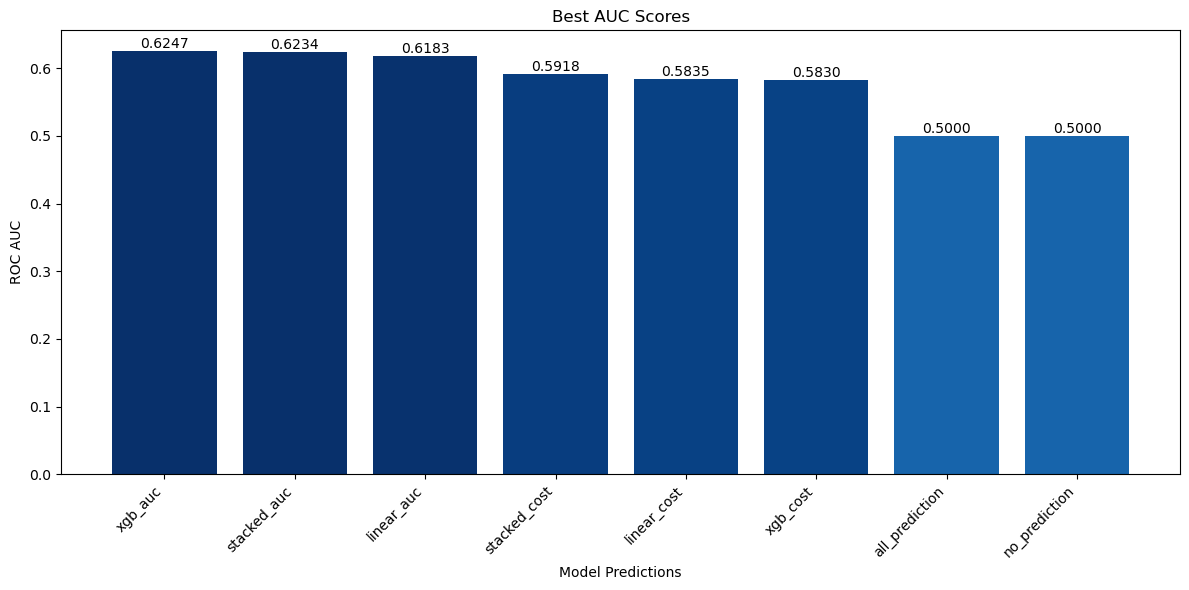

In [72]:
optimal_model_barchart(best_models, "Best AUC Scores", "Model Predictions", "ROC AUC", ROC_AUC, 4)

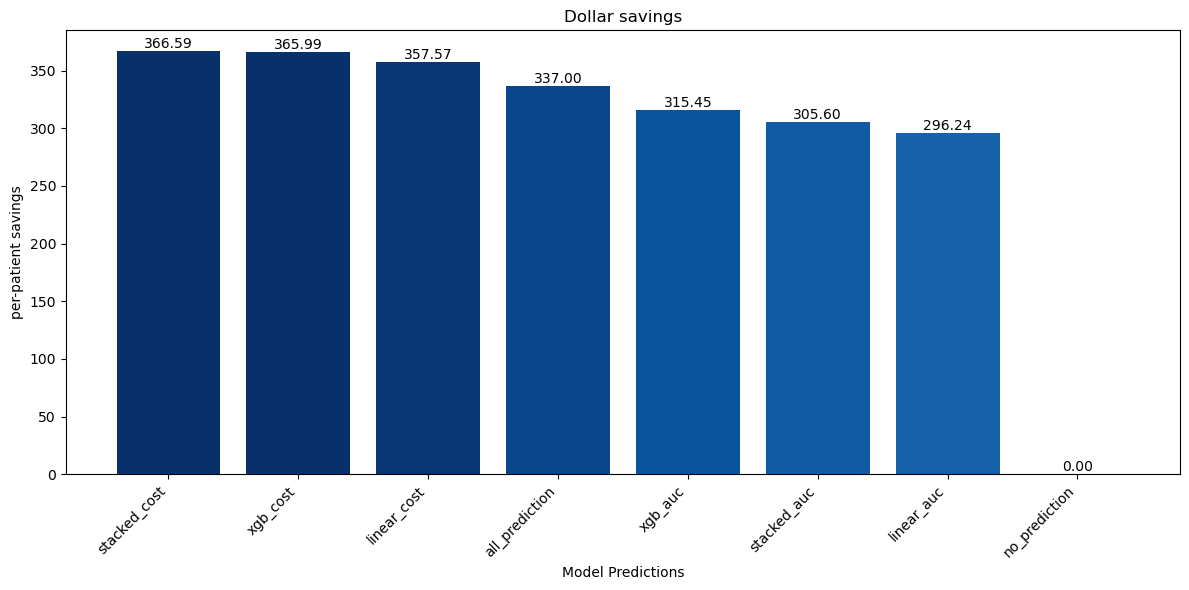

In [73]:
optimal_model_barchart(best_models, "Dollar savings", "Model Predictions", "per-patient savings", cost, 2)

As can be seen in the above: <br>
The best AUC is realized through an XGBoost model (.625) , with a stacked model performing closely behind (.623) <br>
Alternately, the highest cost savings can be seen through a stacked model (366.59 dollars) with a pure XGBoost model performing at (365.99 dollars)

**As saving money is a more tangible/applicible outcome than an esoteric statistical concept like AUC ROC, we will be focusing on cost savings for our "best" model.**

Before evaluating our "best" model (i.e. the stacked cost-reducing model), it is worth considering another metric that could be assessed, **that being prevented readmissions.**

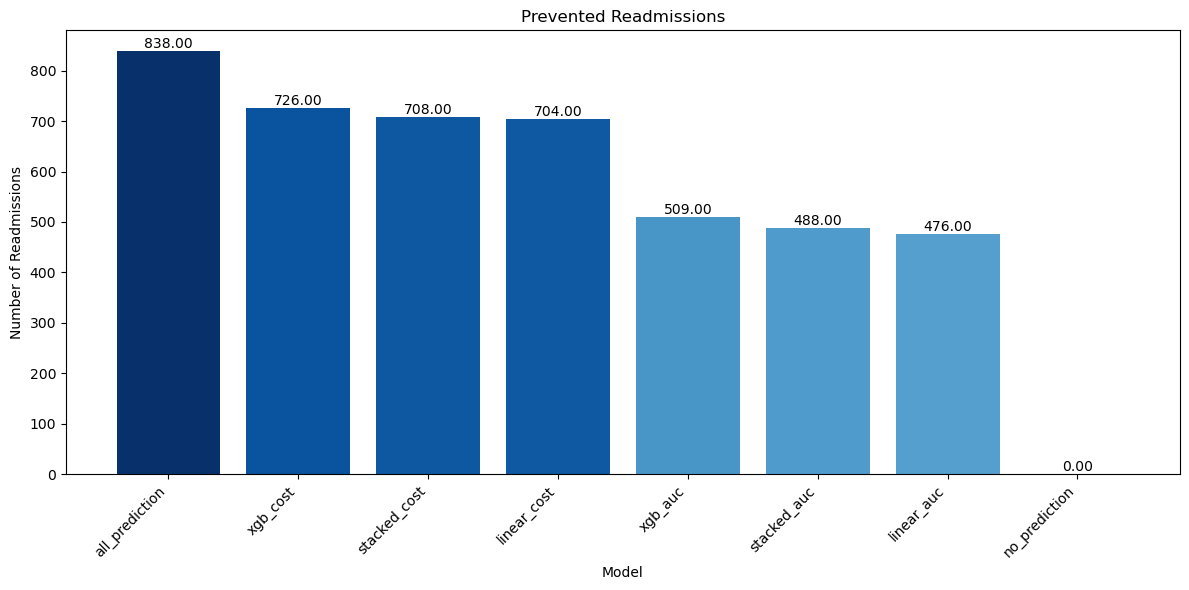

In [74]:
optimal_model_barchart(best_models, "Prevented Readmissions", "Model", "Number of Readmissions", Prevented_Readmissions, 2)

As can be seen in the above chart that our default state, (where all patients are considered at risk and therefore enrolled in a diabetes-management-program) results in the highest number of readmissions being predicted.

Indeed, this makes sense, as every patient recieves an intervention. Indeed, with our parameters, this still saves over $300 per patient, as reducing readmissions saves, according to our parameters, enough to cover 30 individual readmission-prevention programs.

However, for the additional ~100 or so prevented readmissions, the average savings per-patient decreases. This implies that for each prevented readmission, we are employing enough unecessary prevention programs, so that the cost of these programs exceeds the savings from the single reasmission. This implies that we are seeing a diminishing return on investment.

It must be remembered that saved dollars can be allocated elsewhere to provide additional value (e.g. they could be used to improve the the efficacy of the diabetes-readmission-program, resulting in further reduced readmissions, by prioritizing resources on patients who need it most

**As such, we will continue to focus on the cost savings model as our "best" model iteration. This model takes into account the relative risk of each patient (unlike the blanket approach) while still correctly identifying the vast majority of True Positives.**

Relative to both of these models, it can be seen that all of the AUC optimized models perform worse at preventing readmissions. That is largely due to the fact that the ROC AUC metric models places an emphasis on identifying the number of True Negatives (i.e. patients that will not be readmitted) and as such underemphasizes identifying True Positives, relative to our predictions focused on cost-prevention.

However, from a public health perspective, it must be noted that substantial savings and prevented readmissions can be achieved without fancy machine learning, by simply applying preventative, cost-effecient steps when caring for high-risk procedures like diabetes readmissions.

#### Below is a confusion matrix to better visualize our "best" model (i.e. the stacked cost-optimized model):

In [75]:
def Plot_Confusion_Matrix(y_true, y_pred, classes,
                             normalize=False,
                             title=None, 
                             cmap=None,
                             figsize=(6, 6),
                             xticks=None,
                             yticks=None,
                             show_colorbar=True):  # Add a parameter to control the colorbar

    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    
    # Remove the colorbar if show_colorbar is set to False
    if not show_colorbar:
        ax.figure.colorbar(im, ax=ax).remove()
    
    # We want to show all ticks...
    ax.set(xticks=xticks if xticks else np.arange(cm.shape[1]),
           yticks=yticks if yticks else np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Actual',
           xlabel='Predicted')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    
    # Add space between the title and the chart
    plt.subplots_adjust(top=0.8)  # Adjust the top margin as needed
    
    fig.tight_layout()
    return ax


#### Defining additional variables for our confusion matrix

In [77]:
class_names = np.array(['Not Readmitted', 'Readmitted'])
y_test = diabetes_test['readmitted']
y_pred_stacked_cost = stacked_cost_more_precise_thresholds[5]
y_pred_xgb_cost = xgb_more_precise_thresholds_cost[3]

#### Creating a connfusion matrix for our optimized model

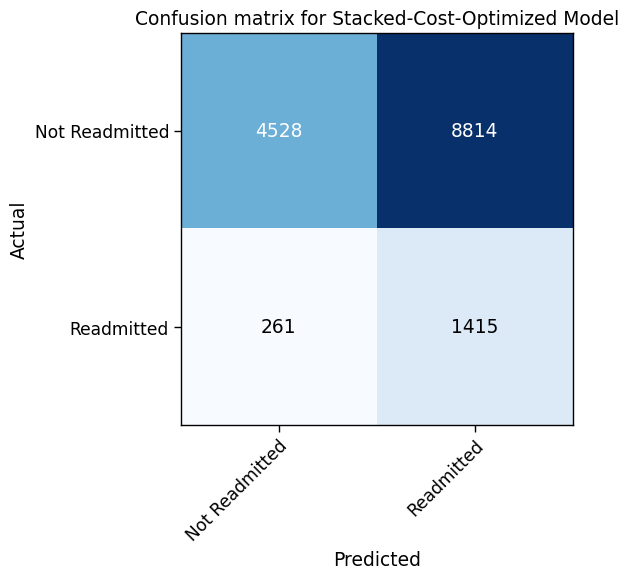

In [78]:
%matplotlib inline
sns.set_context("paper", font_scale=1.4)

y_test = diabetes_test['readmitted']
y_pred = y_pred_stacked_cost

class_names = np.array(['Not Readmitted', 'Readmitted'])

# Plot non-normalized confusion matrix
Plot_Confusion_Matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix for Stacked-Cost-Optimized Model',
                      cmap=plt.cm.Blues)
plt.grid(False)

plt.show()

#### Output metrics for our optimized model

In [79]:
best_models.loc['stacked_cost']

Cutoff_Percentage            8.20%
ROC_AUC                   0.591826
Net_Cost_Savings            366.59
Prevented_Readmissions         708
Recall                    0.844272
Precision                 0.138332
F1_Score                  0.237715
Accuracy                  0.395725
PR AUC                    0.499992
True_Positives                1415
False_Positives               8814
False_Negatives                261
Specificity               0.339379
Per-Patient Savings         707.15
Up_front_Expense            340.56
Type_of_assessment         stacked
Name: stacked_cost, dtype: object

For additional assessment of these results, please see the accompanying analysis page: https://wbst-bkt.s3.amazonaws.com/index.html